In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

# Rounding

Rounding is useful when we have a set of numbers we want to work with, but our transformations on these number might take us out of the set. If we consider this as a group, adding rounding to the transformation provides closure. For example, if we consider the integers and division. This is obviously not closed, but if we change the operation to be the rounded result to the nearest integer of division, it would allow for closure.

The obvious issue is rounding changes the number. For example, if we compute division of an odd number $n$ by $2$, we get $\left\lfloor n/2\right\rfloor + 1=\left\lceil n/2 \right\rceil$, which always increases the value. If we turn to statistics, we have succinct notation by using expected values. $E(n/2)=\left\lceil n/2 \right\rceil$. This causes chaotic functions' error to spiral out over time, as it always will increase the division.

This obviously applies to any number that can not cleanly be represented in binary. Due to how our computers are operated, we always have to round any numbers whose prime factorization includes primes other than $2$. We could keep everything in perfect fractions, but this is very computationally intensive and not ideal.

One way to view how out of hand this gets is through the Bernoulli Map on the unit circle. The unit circle is the 0 to 1 number line wrapped in a circle. The formal definitions are below.

$$
        \begin{align*}
            S'&\equiv[0,1]/\sim, 0\sim1\\
            &\equiv\mathbb{R}/\sim, x\sim w \text{ if } x-w\in\mathbb{Z}\\
            &\equiv(\mathbb{R},+)/(\mathbb{Z},+)
        \end{align*}
$$

We are using the Bernoulli map because it is easy to calculate exactly, easy to compare numbers as runtime increases, and easy to understand. The Bernoulli Map is also known as the doubling map and the Bernoulli Map is defined below.

$$
\begin{align*}
    B:&\mathbb{R}\to\mathbb{R}\\
      &x\mapsto 2\cdot x
\end{align*}
$$

We're also going to define the generalized Bernoulli Map, as it is easier to show the advantages of stochastic rounding using other factors than $2$

$$
\begin{align*}
    B_n:&\mathbb{R}\to\mathbb{R}\\
      &x\mapsto n\cdot x
\end{align*}
$$

For $B_{1.2}$, we can numerically find an orbit using a graphing calculator. I've gone ahead and done that and found that for $x\approx 0.399404, f^{10}(x)=x$. Fun fact, this is the smallest orbit other than $x=0$ for this generalized Bernoulli Map, which according to Sharkovskii's theorem allows us to know that there exists an orbit of every length that appears after $10$ in the Sharkovskii Ordering.

Fun fact, all the dyadic rationals in the Bernoulli Map are a pre-orbit of 0!

In [2]:
def bernoulli_map(x):
    return (x * 1.2) % 1

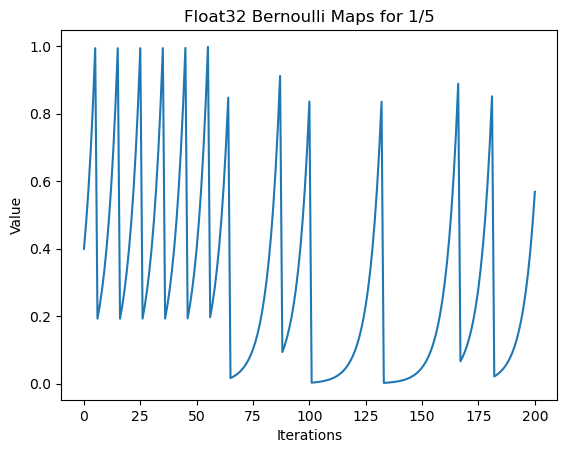

In [3]:
b_third = [np.float32(0.399404)]

for i in range(200):
    b_third.append(bernoulli_map(b_third[-1]))

plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Float32 Bernoulli Maps for 0.399404")
plt.plot(range(len(b_third)), b_third)

Average Error: 0.47710750403211943


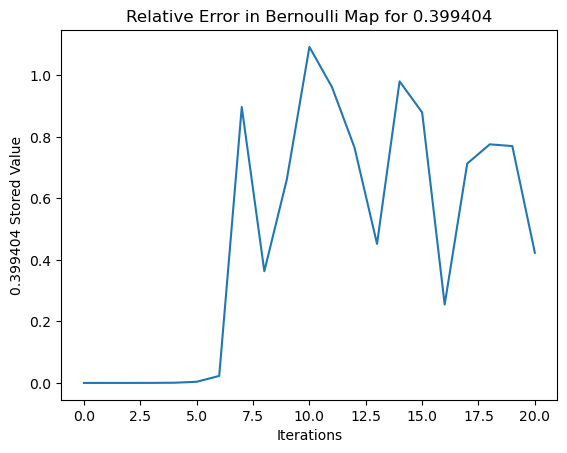

In [4]:
# Lets look at just the value of what should be 0.399404
b_third_reduced = b_third[0::10]
third_rel_err = abs(b_third_reduced - np.float64(0.399404)) / np.float64(0.399404)

plt.xlabel("Iterations")
plt.ylabel("0.399404 Stored Value")
plt.title("Relative Error in Bernoulli Map for 0.399404")
plt.plot(range(len(third_rel_err)), third_rel_err)

print(f"Average Error: {sum(third_rel_err) / len(third_rel_err)}")

Loop Iteration Mean: 42.083333333333336
f=10 : 6.252773284912109
f=8-12 : 26.290512084960938
Percent of f=10 over the first 20: 0.0358399972319603
Percent of f=8-12 over the first 20: 0.15069344639778137


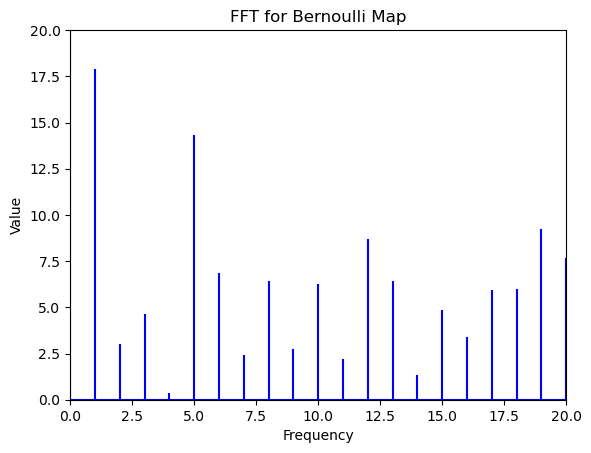

In [5]:
# Fourier Transform Analysis
reg_fft = np.abs(np.fft.fft(b_third))
plt.stem(range(201), np.abs(reg_fft), 'b', \
         markerfmt=" ", basefmt="-b")

loop = []
for i in range(len(b_third) - 1):
    if b_third[i + 1] < b_third[i]:
        i_add = i
        if len(loop) > 0:
            i_add = i - loop[-1]
        loop.append(i_add)

print(f"Loop Iteration Mean: {np.mean(loop)}")

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.ylabel("Value")
plt.xlabel("Frequency")
plt.title("FFT for Bernoulli Map")

# Value for 10 iterations
print(f"f=10 : {reg_fft[10]}")
print(f"f=8-12 : {sum(reg_fft[8:13])}")
print(f"Percent of f=10 over the first 20: {reg_fft[10] / sum(reg_fft[:20])}")
print(f"Percent of f=8-12 over the first 20: {sum(reg_fft[8:13]) / sum(reg_fft[:20])}")

# Stochastic Rounding

One approach to solve this problem is to use stochastic rounding. This type of rounding rounds up or down depending on a probability. Given a set of numbers $G$ that we want to use and a number $n\not\in G$, we can find $g_1,g_2\in G$ such that $g_1<n<g_2$, where $g_1,g_2$ are the closest numbers in $G$ to $n$.

We then round up with probability $\frac{n-g_1}{g_2-g_1}$ and round down with probability $\frac{g_2-n}{g_2-g_1}$. If we use this type of rounding in the division scenario above, we change the expected value to $E(n/2)=n/2$. This should fix the large deviations we see in the map.

First, we'll show a simpler case with a new function that shouldn't be stable but is under regular rounding.
$$
\begin{align*}
    f:&\mathbb{Z}\to\mathbb{Z}\\
      &x\mapsto 4 \cdot (x / 3)
\end{align*}
$$

There doesn't seem to be a current Python library that does this, so I will be manually doing this for $f$ and $\frac{n^2}{5}\mod 1$.

[np.float64(4.0), np.float64(5.333333333333333), np.float64(7.111111111111111), np.float64(9.481481481481481), np.float64(12.641975308641975), np.float64(16.8559670781893), np.float64(22.474622770919062), np.float64(29.966163694558748), np.float64(39.95488492607833), np.float64(53.27317990143777), np.float64(71.03090653525035)]


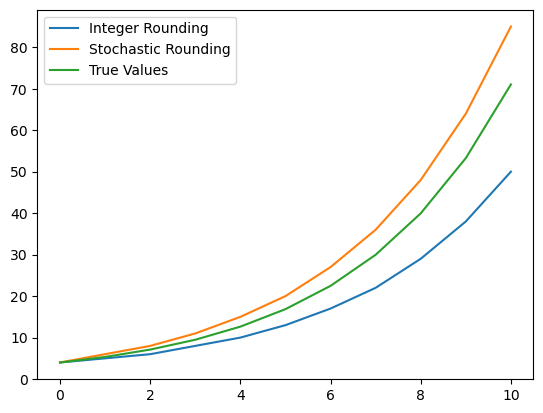

In [21]:
def f(x):
    return int(4 * x / 3)

def f_stoch(x):
    tv = 4.0 * x / 3.0
    ival = [ int(tv) ]
    if np.isclose(ival[0], tv):
        return ival[0]
    elif ival[0] > tv:
        ival.append(ival[0] - 1)
    else:
        ival.append(ival[0] + 1)
    ival.sort()
    if random.random() < (tv-ival[0]) / (ival[1]-ival[0]):
        return ival[1]
    return ival[0]

iterations = 10
reg = [4]
stoch = [4]
tval = [np.float64(4.0)]

for i in range(iterations):
    reg.append(f(reg[-1]))
    stoch.append(f_stoch(stoch[-1]))
    tval.append(np.float64(4.0 / 3.0 * tval[-1]))

print(tval)

plt.plot(range(iterations + 1), reg, label="Integer Rounding")
plt.plot(range(iterations + 1), stoch, label = "Stochastic Rounding")
plt.plot(range(iterations + 1), tval, label = "True Values")
plt.legend()

In [20]:
class Float32SR():
    def __init__(self, x, size):
        self.data = []
        self.size = size
        for i in range(size):
            self.data.append(self.stoch_round(x))
            
    def stoch_round(self, tp):
        p = [np.float32(tp)]
        p.append(np.nextafter(p[0], 2 if p[0] < tp else -1))
        p.sort()
        if random.random() < (tp-p[0]) / (p[1]-p[0]):
            return p[1]
        return p[0]
        
    def stoch_round_all(self, tp):
        s = np.average(np.array(tp, dtype=np.float64))
        p = [ self.stoch_round(s) for i in range(self.size) ]
        self.data = p

    def stoch_prod(self, x, mod=False):
        tx = np.float64(x)
        tp = [ tx * np.float64(y) for y in self.data ]
        if mod:
            for i in range(len(tp) - 1):
                while tp[i] >= 1:
                    tp[i] -= 1
        self.stoch_round_all(tp)
        return self.__copy__()

    def data(self):
        return self.data

    def val(self):
        s = np.average(np.array(self.data, dtype=np.float64))
        return self.stoch_round(s)

    def __str__(self):
        return str(self.val())

    def __copy__(self):
        copy = Float32SR(0, self.size)
        copy.data = self.data.copy()
        return copy

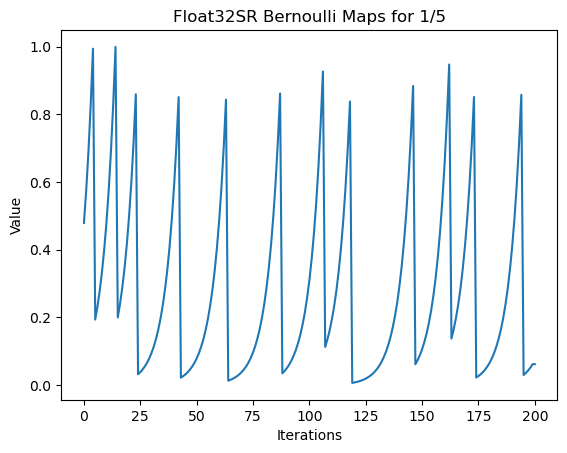

In [8]:
def bernoulli_stoch(x, n=np.float64(1.2)):
    return x.stoch_prod(n, True)

iterations = 200
stoch = [Float32SR(np.float64(0.399404), 1000)]

for i in range(iterations):
    stoch.append(bernoulli_stoch(stoch[-1]))

stoch_vals = [s.val() for s in stoch]

plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Float32SR Bernoulli Maps for 0.399404")
plt.plot(range(iterations + 1), stoch_vals)

Average Error: 0.5368479066830998


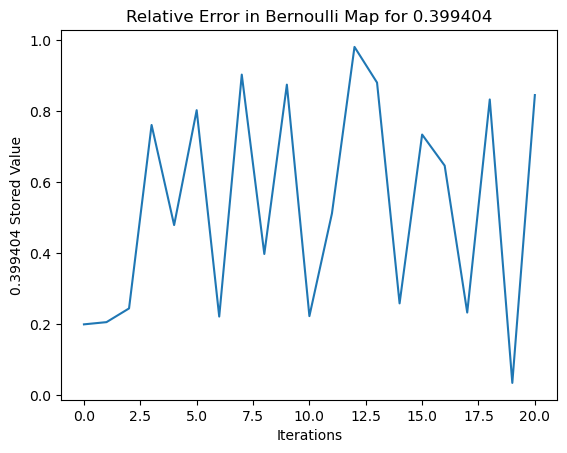

In [9]:
# Lets look at just the value of what should be 0.399404
stoch_red = stoch_vals[0::10]
stoch_rel_err = abs(stoch_red - np.float64(0.399404)) / np.float64(0.399404)

plt.xlabel("Iterations")
plt.ylabel("0.399404 Stored Value")
plt.title("Relative Error in Bernoulli Map for 0.399404")
plt.plot(range(len(stoch_rel_err)), stoch_rel_err)

print(f"Average Error: {sum(stoch_rel_err) / len(stoch_rel_err)}")

Loop Iteration Mean: 51.416666666666664
f=10 : 8.853890419006348
f=8-12 : 38.84628677368164
Percent of f=10 over the first 20: 0.05029485747218132
Percent of f=8-12 over the first 20: 0.2206677943468094


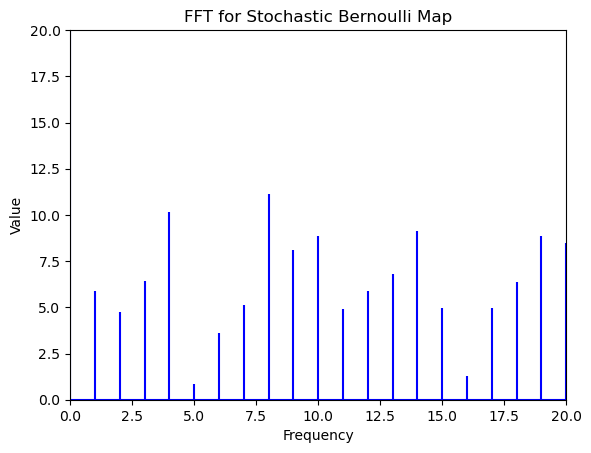

In [10]:
# Fourier Transform Analysis
stoch_fft = np.abs(np.fft.fft(stoch_vals))
plt.stem(range(201), np.abs(stoch_fft), 'b', \
         markerfmt=" ", basefmt="-b")
loop = []
for i in range(len(stoch_vals) - 1):
    if stoch_vals[i + 1] < stoch_vals[i]:
        i_add = i
        if len(loop) > 0:
            i_add = i - loop[-1]
        loop.append(i_add)

print(f"Loop Iteration Mean: {np.mean(loop)}")

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.ylabel("Value")
plt.xlabel("Frequency")
plt.title("FFT for Stochastic Bernoulli Map")

print(f"f=10 : {stoch_fft[10]}")
print(f"f=8-12 : {sum(stoch_fft[8:13])}")
print(f"Percent of f=10 over the first 20: {stoch_fft[10] / sum(stoch_fft[:20])}")
print(f"Percent of f=8-12 over the first 20: {sum(stoch_fft[8:13]) / sum(stoch_fft[:20])}")

# Sharkovskii's Thereom and Bernoulli's Map

While stochastic rounding improves the Bernoulli Map (even better with other people's implementation), we can get much more accurate solutions using Pythons Fractions library. This is computationally slow, and since we are doing continuous mappings, we can build a much better class for handling fractions in Bernoulli's Map. First lets implement it using Pythons Fractions.

In [11]:
%%time

def b_map(x):
    x = x * 2
    while x >= 1:
        x -= 1
    return x

denominator = (2**2) * 5 * 7 * 3**2
iterations = 1000
decimal = []

for i in range(denominator):
    decimal.append([i / denominator])

for i in range(iterations):
    for j, dec in enumerate(decimal):
        decimal[j].append(b_map(dec[-1]))

CPU times: user 357 ms, sys: 19.9 ms, total: 377 ms
Wall time: 378 ms


<Axes: >

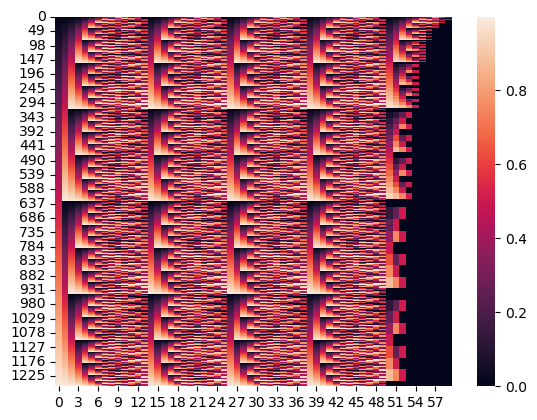

In [12]:
import seaborn as sns

sns.heatmap([[float(j) for j in i[:60]] for i in decimal])

In [13]:
%%time

from fractions import Fraction

fractions = []

for i in range(denominator):
    fractions.append([Fraction(i, denominator)])

for i in range(iterations):
    for j, frac in enumerate(fractions):
        fractions[j].append(b_map(frac[-1]))

CPU times: user 3.85 s, sys: 21.3 ms, total: 3.87 s
Wall time: 3.88 s


<Axes: >

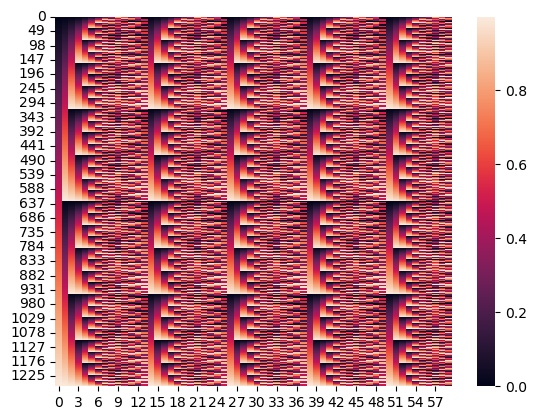

In [14]:
sns.heatmap([[float(j) for j in i[:60]] for i in fractions])

In [15]:
class SFBernoulli():
    def __init__(self, numerator, denominator, factor):
        self.position = 0
        if numerator == 0:
            self.numerator = numerator
            self.denominator = 1
            self.loop = [0]
            self.loop_start = 0
            return
        while numerator != 1 and denominator % numerator == 0:
            denominator /= numerator
            numerator /= numerator
        self.numerator = numerator
        self.denominator = denominator
        self.factor = factor
        self.loop = []
        self.loop_start = 0
        n = 1
        self.loop.append(numerator)
        while self.factor**n % denominator != 1:
            cur_numerator = (self.factor**n * numerator) % denominator
            if cur_numerator in self.loop:
                self.loop_start = self.loop.index(cur_numerator)
                break
            else:
                self.loop.append(cur_numerator)
                n += 1

    def iterate(self):
        if self.position == len(self.loop) - 1:
            self.position = self.loop_start
        else:
            self.position += 1

    def num(self):
        return self.loop[self.position] / self.denominator

In [16]:
%%time

sfractions = []
svals = []

for i in range(denominator):
    sfractions.append(SFBernoulli(i, denominator, 2))
    svals.append([sfractions[i].num()])

for i in range(iterations):
    for j in range(len(sfractions)):
        sfractions[j].iterate()
        svals[j].append(sfractions[j].num())

CPU times: user 373 ms, sys: 16 ms, total: 389 ms
Wall time: 389 ms


<Axes: >

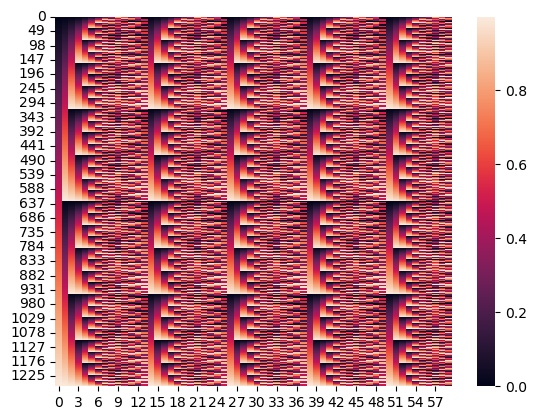

In [17]:
sns.heatmap([[j for j in i[:60]] for i in svals])